In [1]:
import cv2
import matplotlib.pyplot as plt
import imutils
import numpy as np
import ntpath
import os
import xml.etree.ElementTree as ET

In [2]:
def slice_img(img):
    img2 = img.copy()
    for wid in range(0, img2.shape[0], 640):
         for height in range(0, img2.shape[1], 640):
            sliced_img = img2[wid:wid + 640, height:height + 640]
            plt.figure(figsize=(10, 5))
            plt.imshow(cv2.cvtColor(sliced_img, cv2.COLOR_BGR2RGB))

    resized_image = cv2.resize(img, (640, 640)) 
    print(resized_image.shape)

    plt.figure(figsize=(15, 5))
    plt.imshow(cv2.cvtColor(scaled, cv2.COLOR_BGR2RGB))
    
def MakeXMLFile(path: str, xmins, xmaxs, ymins, ymaxs, classnames, number):
    subdirectory_name = "SlicedImages"
    margin_lvl = 0
    file_path, filename = ntpath.split(path)
    _, folder = ntpath.split(file_path)
    img = cv2.imread(path)
    height, width, depth = img.shape
    XMLfilename = filename.split('.')[0]
        
    with open(file_path + "/" + subdirectory_name + "/" + XMLfilename + str(number) + '.xml', 'w') as f:
        f.write('<annotation>\n')
        margin_lvl += 1
        f.write('\t'*margin_lvl + f'<folder>{folder}</folder>\n')
        f.write('\t'*margin_lvl + f'<filename>{filename}</filename>\n')
        f.write('\t'*margin_lvl + f'<path>{path}</path>\n')
        f.write('\t'*margin_lvl + f'<source>\n')
        margin_lvl += 1 
        f.write('\t'*margin_lvl + '<database>Unknown</database>\n')
        margin_lvl -= 1
        f.write('\t'*margin_lvl + f'</source>\n')
        f.write('\t'*margin_lvl + '<size>\n')
        margin_lvl += 1
        f.write('\t'*margin_lvl + f'<width>{width}</width>\n')
        f.write('\t'*margin_lvl + f'<height>{height}</height>\n')
        f.write('\t'*margin_lvl + f'<depth>{depth}</depth>\n')
        margin_lvl -= 1
        f.write('\t'*margin_lvl + '</size>\n')
        f.write('\t'*margin_lvl + '<segmented>0</segmented>\n')
        
        for xmin, xmax, ymin, ymax, class_name in zip(xmins, xmaxs, ymins, ymaxs, classnames):
#             xmin, ymin, xmax, ymax = contour[0], contour[1], contour[0] + contour[2], contour[1] + contour[3]
            f.write('\t'*margin_lvl + '<object>\n')
            margin_lvl += 1
            f.write('\t'*margin_lvl + f'<name>{class_name}</name>\n')
            f.write('\t'*margin_lvl + f'<pose>Unspecified</pose>\n')
            f.write('\t'*margin_lvl + f'<truncated>0</truncated>\n')
            f.write('\t'*margin_lvl + f'<difficult>0</difficult>\n')
            f.write('\t'*margin_lvl + '<bndbox>\n')
            margin_lvl += 1
            f.write('\t'*margin_lvl + f'<xmin>{xmin}</xmin>\n')
            f.write('\t'*margin_lvl + f'<ymin>{ymin}</ymin>\n')
            f.write('\t'*margin_lvl + f'<xmax>{xmax}</xmax>\n')
            f.write('\t'*margin_lvl + f'<ymax>{ymax}</ymax>\n')
            margin_lvl -= 1
            f.write('\t'*margin_lvl + '</bndbox>\n')
            margin_lvl -= 1
            f.write('\t'*margin_lvl + '</object>\n')
        
        f.write('</annotation>')

In [37]:
img = cv2.imread('D:/projects/CornClassifier/resources/IMG_4330_wb.jpg')

In [38]:
from time import sleep
# tree = ET.parse('D:/projects/CornClassifier/resources/IMG_4330_wb.xml')
# root = tree.getroot()
# img2 = img.copy()
img_size = (640, 640)
bound_box_margin = 2

label_classname = {
    'mais' : 0,
    'dill' : 1,
    'buckwheat': 2,
    'other': 3
}
label_to_classname = {v: k for k, v in label_classname.items()}

for i in range(4310, 4331):
    img = cv2.imread(f'D:/projects/CornClassifier/resources/IMG_{i}_wb.jpg')
    tree = ET.parse(f'D:/projects/CornClassifier/resources/IMG_{i}_wb.xml')
    root = tree.getroot()
    img2 = img.copy()

    bounds = np.array([(int(xmin.text), int(xmax.text), int(ymin.text), int(ymax.text), label_classname[name.text]) for xmin, xmax, ymin, ymax, name in zip(root.findall('.//xmin'),\
                                        root.findall('.//xmax'), root.findall('.//ymin'), root.findall('.//ymax'), root.findall('.//name'))])


    count = 0
    path = f'D:/projects/CornClassifier/resources/IMG_{i}_wb.jpg'
    for wid in range(0, img.shape[0] - 640, img_size[0]):
        for hei in range(0, img2.shape[1] - 640, img_size[1]):
            sliced_bounds = bounds[(bounds[:, 0] < wid + 640) & (bounds[:, 0] > wid) & (bounds[:, 2] < hei + 640) & (bounds[:, 2] > hei)]
            classname = list(map(label_to_classname.get, sliced_bounds[:, 4]))
            xmins = sliced_bounds[:, 0]
            xmaxs = sliced_bounds[:, 1]
            ymins = sliced_bounds[:, 2]
            ymaxs = sliced_bounds[:, 3]
            MakeXMLFile(path, xmins - wid - bound_box_margin, xmaxs - wid - bound_box_margin, ymins - hei - bound_box_margin, ymaxs - hei - bound_box_margin, classname, count)
    #         for xmin, xmax, ymin, ymax, classname in sliced_bounds:
    #             cv2.rectangle(img2, (xmin - bound_box_margin, ymin - bound_box_margin), (xmax + bound_box_margin, ymax + bound_box_margin), (255, 0, 0), 5)
#             plt.figure(figsize=(10, 7))
#             plt.imshow(cv2.cvtColor(img2[hei: hei + 640, wid:wid + 640], cv2.COLOR_BGR2RGB))
            cv2.imwrite(f'D:/projects/CornClassifier/resources/SlicedImages/IMG_{i}_wb{count}.jpg', img2[hei: hei + 640, wid:wid + 640])
            count += 1


0 0
0 640
0 1280
0 1920
0 2560
640 0
640 640
640 1280
640 1920
640 2560
1280 0
1280 640
1280 1280
1280 1920
1280 2560
1920 0
1920 640
1920 1280
1920 1920
1920 2560
0 0


C:\Users\Maxim\AppData\Local\Temp/ipykernel_21960/4011360926.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 7))


0 640
0 1280
0 1920
0 2560
640 0
640 640
640 1280
640 1920
640 2560
1280 0
1280 640
1280 1280
1280 1920
1280 2560
1920 0
1920 640
1920 1280
1920 1920
1920 2560
0 0
0 640
0 1280
0 1920
0 2560
640 0
640 640
640 1280
640 1920
640 2560
1280 0
1280 640
1280 1280
1280 1920
1280 2560
1920 0
1920 640
1920 1280
1920 1920
1920 2560
0 0
0 640
0 1280
0 1920
0 2560
640 0
640 640
640 1280
640 1920
640 2560
1280 0
1280 640
1280 1280
1280 1920
1280 2560
1920 0
1920 640
1920 1280
1920 1920
1920 2560
0 0
0 640
0 1280
0 1920
0 2560
640 0
640 640
640 1280
640 1920
640 2560
1280 0
1280 640
1280 1280
1280 1920
1280 2560
1920 0
1920 640
1920 1280
1920 1920
1920 2560
0 0
0 640
0 1280
0 1920
0 2560
640 0
640 640
640 1280
640 1920
640 2560
1280 0
1280 640
1280 1280
1280 1920
1280 2560
1920 0
1920 640
1920 1280
1920 1920
1920 2560
0 0
0 640
0 1280
0 1920
0 2560
640 0
640 640
640 1280
640 1920
640 2560
1280 0
1280 640
1280 1280
1280 1920
1280 2560
1920 0
1920 640
1920 1280
1920 1920
1920 2560
0 0
0 640
0 1280
0 1

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

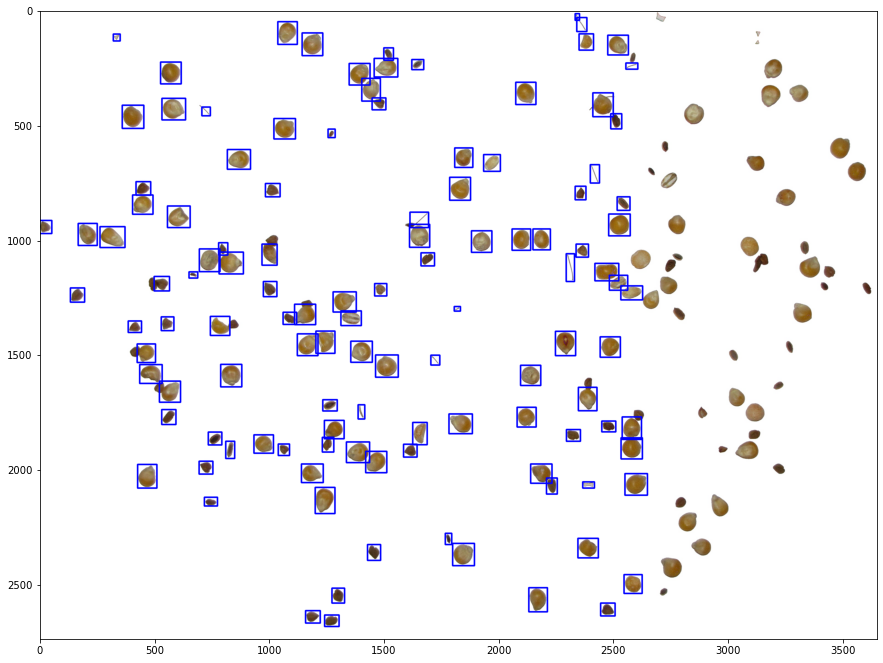

In [29]:
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

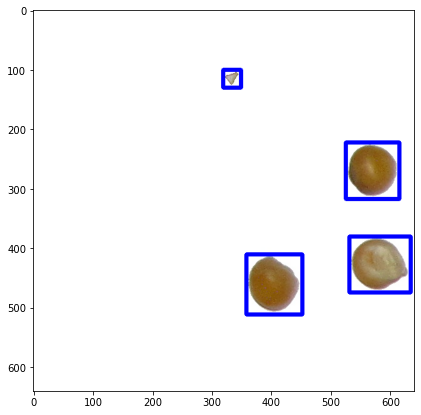

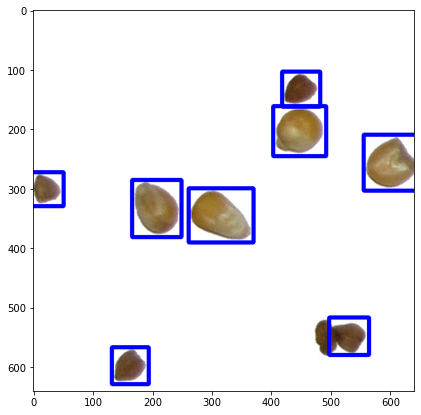

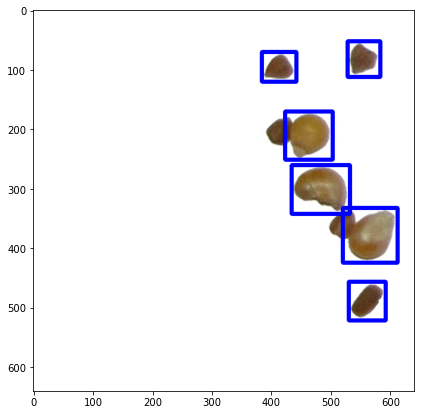

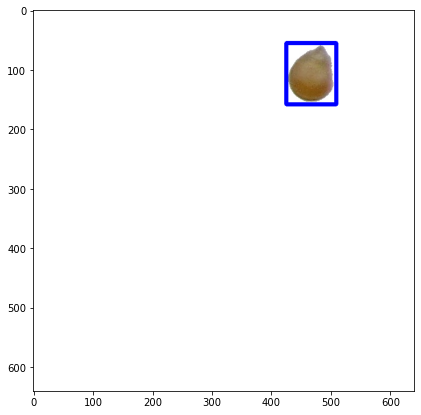

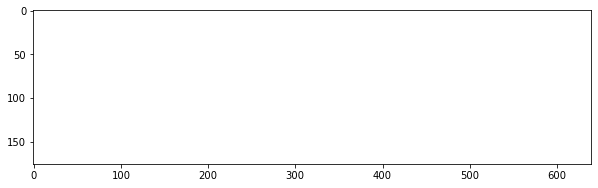

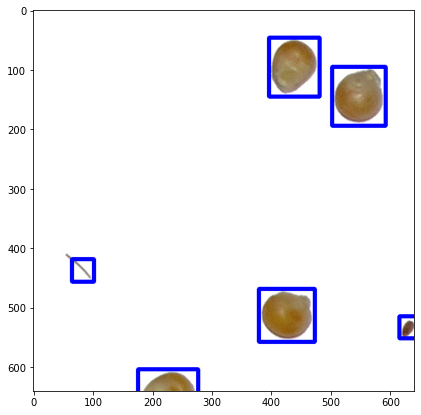

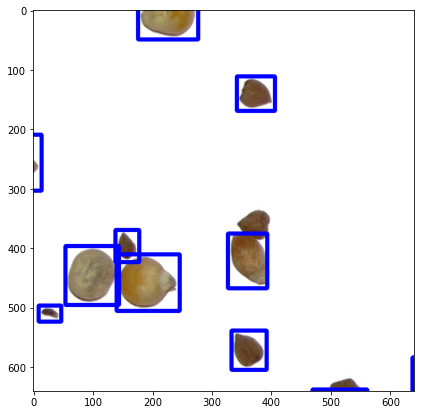

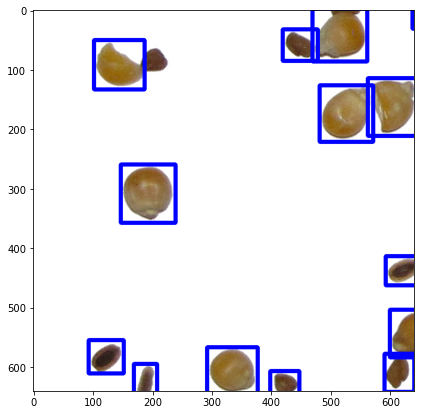

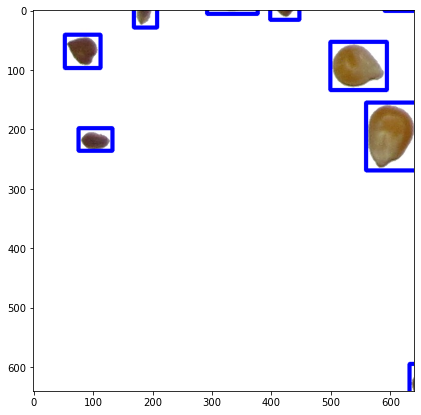

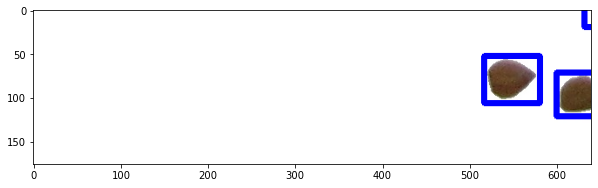

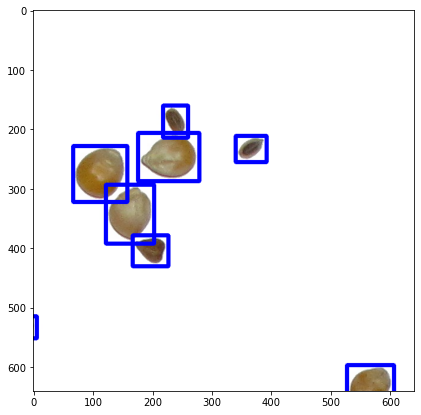

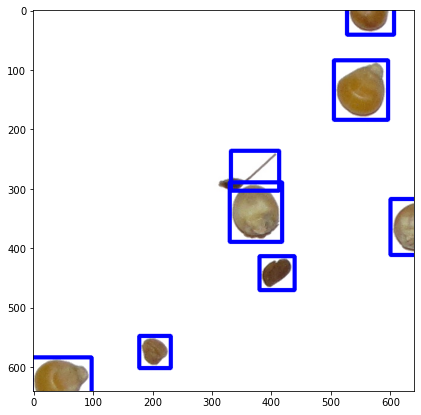

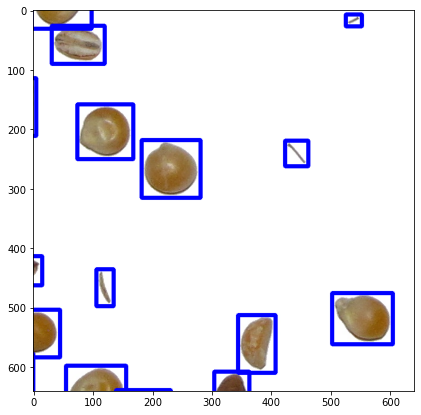

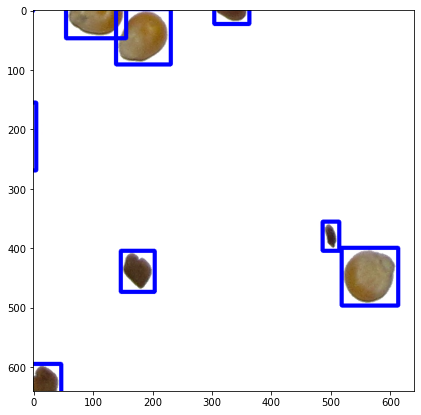

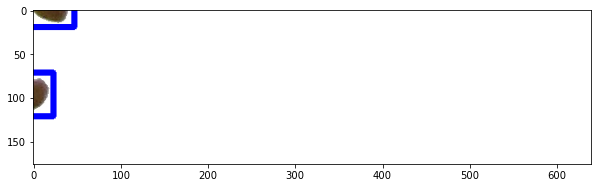

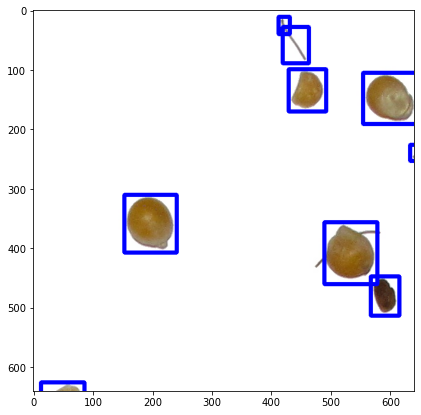

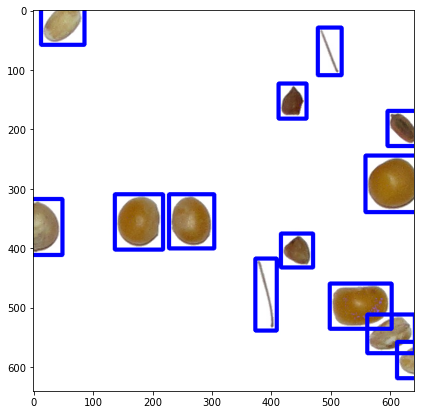

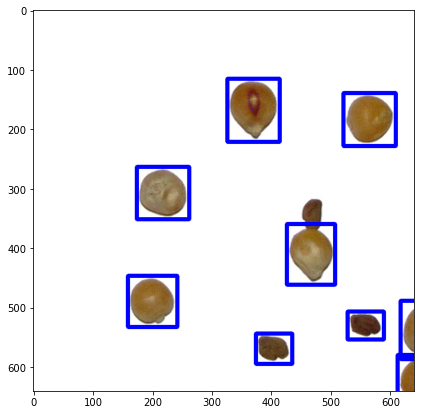

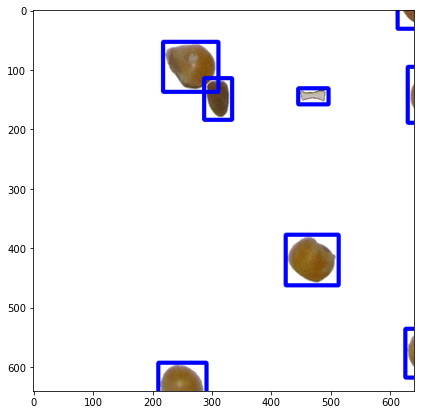

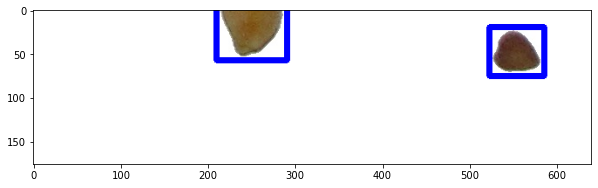

In [26]:
for wid in range(0, img.shape[0]- 640, img_size[0]):
    for hei in range(0, img2.shape[1] - 640, img_size[1]):
        plt.figure(figsize=(10, 7))
        plt.imshow(cv2.cvtColor(img2[ hei: hei + 640, wid:wid + 640], cv2.COLOR_BGR2RGB))